In [1]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 41.5 MB/s eta 0:00:00


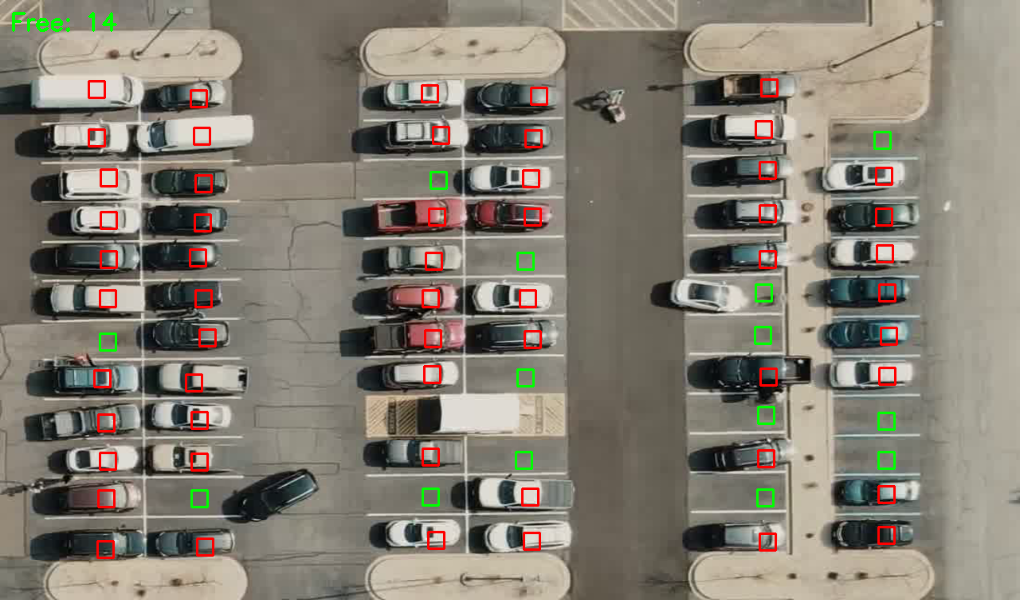

In [ ]:
import cv2
import pickle
import numpy as np
from ultralytics import YOLO
from google.colab.patches import cv2_imshow
import time
from IPython.display import clear_output
import requests
import threading
import subprocess  # مكتبة جديدة لتشغيل FFmpeg
import os
import signal

#  إعدادات API
API_URL = 'https://phonal-shelli-friskily.ngrok-free.dev/api/cv/update-spots'
API_KEY = 'cv_api_a9d7c1e9b5f845f8a8f91a24deafb329'
LOCATION_ID = '0ac25ec4-308f-4b70-944c-1ea6e922facb'
GATE_ID = '6198c6d5-39ba-4273-9d14-716a349ce07c'

def send_data_to_api(spots_payload):
    headers = { "Content-Type": "application/json", "X-CV-API-KEY": API_KEY }
    body = { "locationId": LOCATION_ID, "gateId": GATE_ID, "spots": spots_payload }

    try:
        requests.post(API_URL, json=body, headers=headers, timeout=2)
    except:
        pass # تبسيط للكود في حالة البث المباشر لتجنب تعليق الستريم

# ==========================================
# 🎥 إعدادات محاكاة البث المباشر (FFmpeg Stream)
# ==========================================

VIDEO_PATH = '/content/drive/MyDrive/cv/carPark.mp4'
STREAM_URL = 'udp://127.0.0.1:23000' # الرابط الوهمي للبث

# أمر FFmpeg:
# -re : يقرأ الملف بالسرعة الحقيقية (Real-time) لمحاكاة الكاميرا
# -stream_loop -1 : يكرر الفيديو بلا نهائية
# -f mpegts : صيغة مناسبة للبث عبر الشبكة
ffmpeg_cmd = [
    'ffmpeg',
    '-y', # الموافقة على الكتابة الفوقية
    '-re',
    '-stream_loop', '-1',
    '-i', VIDEO_PATH,
    '-f', 'mpegts',
    '-codec:v', 'mpeg1video', # كودك خفيف وسريع
    '-b:v', '1000k', # التحكم بالـ Bitrate
    '-r', '30', # تثبيت الفريم ريت
    STREAM_URL
]

# إيقاف أي عملية FFmpeg سابقة لتجنب التعارض
os.system("pkill -f ffmpeg")

print("[INFO] Starting FFmpeg Stream Simulation...")
# تشغيل FFmpeg في الخلفية
ff_proc = subprocess.Popen(ffmpeg_cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

# ننتظر قليلاً حتى يبدأ البث
time.sleep(2)

# ==========================================
#  إعدادات النموذج والمجسات
# ==========================================

LAYOUT_FILE = '/content/drive/MyDrive/cv/parking_layout_new2.pkl'
SENSOR_W, SENSOR_H = 20, 20

try:
    with open(LAYOUT_FILE, 'rb') as f:
        sensorList = pickle.load(f)
    print(f"[INFO] Loaded {len(sensorList)} sensors.")
except:
    print("[ERROR] Layout file not found!")
    sensorList = []

previous_states = [None] * len(sensorList)

print("[INFO] Loading YOLO Model...")
model = YOLO('https://huggingface.co/mshamrai/yolov8s-visdrone/resolve/main/best.pt')

# 👇 التغيير الجوهري: القراءة من رابط الـ UDP بدلاً من الملف
print(f"[INFO] Connecting to Stream: {STREAM_URL}")
cap = cv2.VideoCapture(STREAM_URL)

PROCESS_W, PROCESS_H = 1280, 720
DISPLAY_W, DISPLAY_H = 1020, 600

frame_skip = 5 # يمكن زيادتها لأن البث المباشر قد يكون أسرع
count = 0
first_run = True

try:
    while True:
        ret, frame = cap.read()

        if not ret:
            print("[WARNING] Frame dropped or stream disconnected. Retrying...")
            time.sleep(0.1)
            # في حالة الستريم الحقيقي، لا نكسر اللوب بل نحاول القراءة مجدداً
            # إذا توقف البث تماماً يمكن إعادة فتح الـ cap
            continue

        count += 1
        if count % frame_skip != 0: continue

        frame_process = cv2.resize(frame, (PROCESS_W, PROCESS_H))

        # YOLO Prediction
        results = model.predict(frame_process, conf=0.15, verbose=False)

        car_boxes = []
        for r in results:
            for box in r.boxes:
                x1, y1, x2, y2 = box.xyxy[0]
                area = (x2 - x1) * (y2 - y1)
                if area > 800:
                    car_boxes.append([int(x1), int(y1), int(x2), int(y2)])

        occupied_count = 0
        frame_display = frame_process.copy()
        updates_to_send = []

        for i, sensor_pos in enumerate(sensorList):
            sx1, sy1 = sensor_pos
            sx2, sy2 = sx1 + SENSOR_W, sy1 + SENSOR_H
            spot_id = i + 1
            is_occupied = False

            for car in car_boxes:
                cx1, cy1, cx2, cy2 = car
                # حساب التقاطع
                ix1 = max(sx1, cx1); iy1 = max(sy1, cy1)
                ix2 = min(sx2, cx2); iy2 = min(sy2, cy2)
                inter_w = max(0, ix2 - ix1)
                inter_h = max(0, iy2 - iy1)
                if (inter_w * inter_h) > (SENSOR_W * SENSOR_H * 0.3):
                    is_occupied = True
                    break

            if first_run or (is_occupied != previous_states[i]):
                updates_to_send.append({
                    "spotNumber": spot_id,
                    "isOccupied": is_occupied
                })
                previous_states[i] = is_occupied

            # رسم المربعات
            color = (0, 0, 255) if is_occupied else (0, 255, 0)
            if is_occupied: occupied_count += 1
            cv2.rectangle(frame_display, (sx1, sy1), (sx2, sy2), color, 2)

        # إرسال البيانات (Thread)
        if updates_to_send:
            threading.Thread(target=send_data_to_api, args=(updates_to_send,)).start()

        first_run = False

        # العرض
        frame_final = cv2.resize(frame_display, (DISPLAY_W, DISPLAY_H))
        cv2.putText(frame_final, f'Free: {len(sensorList) - occupied_count}',
                    (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

        cv2_imshow(frame_final)
        clear_output(wait=True)

except KeyboardInterrupt:
    print("[INFO] Stopping...")

finally:
    # تنظيف العمليات عند الإيقاف
    cap.release()
    ff_proc.kill() # قتل عملية الـ FFmpeg
    print("[INFO] FFmpeg process killed.")